## 1. Gerekli Kütüphaneler

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
from networkx.algorithms import community
from networkx.algorithms import core
import powerlaw
import matplotlib.ticker as ticker
import os
import time
import warnings
warnings.filterwarnings("ignore")

## 2. Veri Yükleme ve Grafı Oluşturma

In [2]:
file_path = 'web-Google.txt'

# Yönlü bir grafik oluşturuyoruz
G = nx.DiGraph()

# Dosyayı oku ve kenarları ekle
with open(file_path, 'r') as f:
    for line in f:
        if line.startswith('#'):
            continue
        src, dst = map(int, line.strip().split())
        G.add_edge(src, dst)

print(f"Düğüm Sayısı: {G.number_of_nodes()}")
print(f"Kenar Sayısı: {G.number_of_edges()}")

Düğüm Sayısı: 875713
Kenar Sayısı: 5105039


## 3. Temel İstatistikler ve Yorumlama

### 3.1 İç ve dış derece

In [ ]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

print(f"Ortalama İç Derece: {np.mean(list(in_degrees.values())):.2f}")
print(f"Ortalama Dış Derece: {np.mean(list(out_degrees.values())):.2f}")

### 3.2 Bağlantı güçleri

In [ ]:
# Komponent analizi (yönlü)
strong_components = list(nx.strongly_connected_components(G))
weak_components = list(nx.weakly_connected_components(G))

print(f"Strongly Connected Components sayısı: {len(strong_components)}")
print(f"Weakly Connected Components sayısı: {len(weak_components)}")

largest_strong = max(strong_components, key=len)
largest_weak = max(weak_components, key=len)

print(f"En büyük Strongly Connected Component boyutu: {len(largest_strong)}")
print(f"En büyük Weakly Connected Component boyutu: {len(largest_weak)}")

### 3.3 Çap

In [ ]:
print("\nÇap hesaplanıyor (bu işlem zaman alabilir)...")
try:
    # Yönlü grafta çap hesaplaması için güçlü bağlı bileşeni kullanıyoruz
    largest_strong_subgraph = G.subgraph(largest_strong)
    diameter = nx.diameter(largest_strong_subgraph)
    print(f"En büyük güçlü bağlı bileşenin çapı: {diameter}")
except nx.NetworkXError:
    print("Çap hesaplanamadı. Graf bağlantılı olmayabilir.")

### 3.4 Ortalama yol uzunluğu

In [3]:
print("\nOrtalama yol uzunluğu hesaplanıyor (bu işlem zaman alabilir)...")
try:
    # Büyük graflar için örnekleme yaparak ortalama yol uzunluğu hesaplama
    sample_size = min(1000, len(largest_strong))
    sample_nodes = np.random.choice(list(largest_strong), size=sample_size, replace=False)

    total_path_length = 0
    count = 0

    for i, source in enumerate(sample_nodes):
        for target in sample_nodes[i+1:]:
            try:
                path_length = nx.shortest_path_length(largest_strong_subgraph, source, target)
                total_path_length += path_length
                count += 1
            except nx.NetworkXNoPath:
                pass

    avg_path_length = total_path_length / count if count > 0 else 0
    print(f"Örnekleme ile ortalama yol uzunluğu: {avg_path_length:.4f}")
except Exception as e:
    print(f"Ortalama yol uzunluğu hesaplanamadı: {e}")

Ortalama İç Derece: 5.83
Ortalama Dış Derece: 5.83
Strongly Connected Components sayısı: 371764
Weakly Connected Components sayısı: 2746
En büyük Strongly Connected Component boyutu: 434818
En büyük Weakly Connected Component boyutu: 855802

Çap hesaplanıyor (bu işlem zaman alabilir)...


KeyboardInterrupt: 

## 4. Derece Dağılımı Analizi
### İç ve Dış Derece Dağılımlarının Analizi

İç derece (in-degree) ve dış derece (out-degree) dağılımlarını analiz ediyoruz. İnternet ağları genellikle güç yasası (power law) dağılımı gösterir - yani çok az sayıda düğümün çok yüksek derecesi vardır, çoğu düğümün ise düşük derecesi vardır.


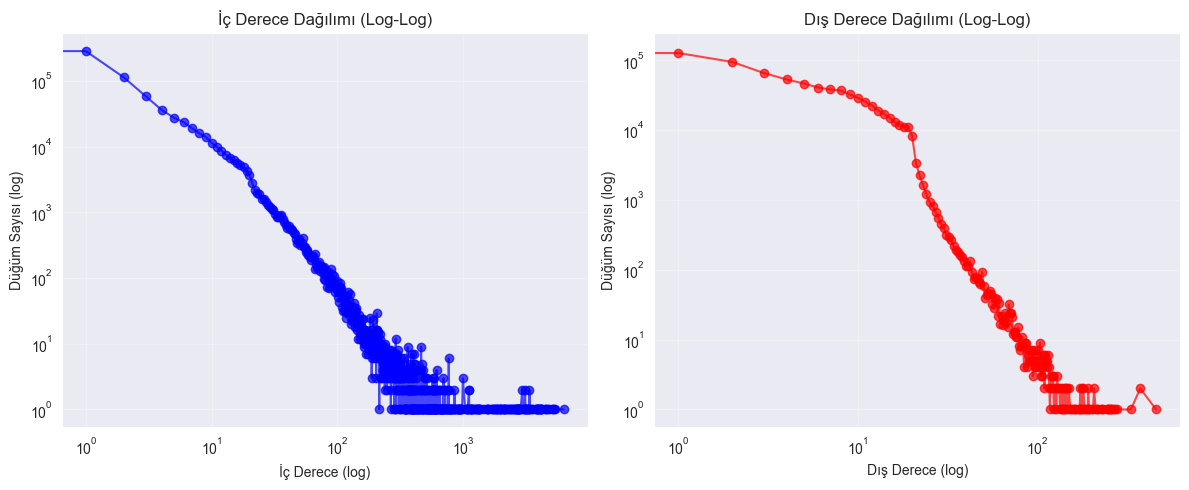

In [4]:
# İç ve dış derece dağılımları
in_degree_values = list(in_degrees.values())
out_degree_values = list(out_degrees.values())

plt.figure(figsize=(12, 5))

# İç derece dağılımı
plt.subplot(1, 2, 1)
in_degree_counts = Counter(in_degree_values)
x = sorted(in_degree_counts.keys())
y = [in_degree_counts[k] for k in x]
plt.loglog(x, y, 'bo-', alpha=0.7)
plt.title('İç Derece Dağılımı (Log-Log)')
plt.xlabel('İç Derece (log)')
plt.ylabel('Düğüm Sayısı (log)')
plt.grid(True, alpha=0.3)

# Dış derece dağılımı
plt.subplot(1, 2, 2)
out_degree_counts = Counter(out_degree_values)
x = sorted(out_degree_counts.keys())
y = [out_degree_counts[k] for k in x]
plt.loglog(x, y, 'ro-', alpha=0.7)
plt.title('Dış Derece Dağılımı (Log-Log)')
plt.xlabel('Dış Derece (log)')
plt.ylabel('Düğüm Sayısı (log)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('degree_distributions.png', dpi=300)
plt.show()

### Güç Yasası Analizi (Power Law)

Web ağlarında, derece dağılımı genellikle güç yasası karakteristiği gösterir. Bu, P(k) ∝ k^(-γ) formülüyle ifade edilir.
Burada γ üstel değerdir ve genellikle 2 ile 3 arasında olması beklenir.

İç derece için güç yasası analizi:
Calculating best minimal value for power law fit
İç derece güç yasası üssü (alpha): 2.6399
İç derece güç yasası xmin: 44.0000

Dış derece için güç yasası analizi:
Calculating best minimal value for power law fit
Dış derece güç yasası üssü (alpha): 3.8212
Dış derece güç yasası xmin: 32.0000


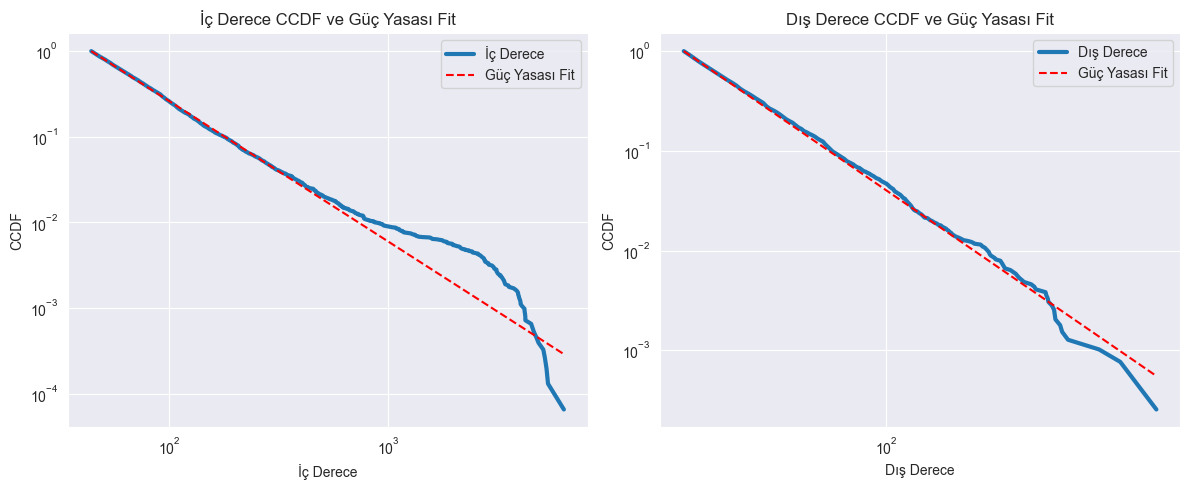

In [5]:
# Güç yasası analizi
try:
    print("İç derece için güç yasası analizi:")
    in_fit = powerlaw.Fit(np.array(in_degree_values) + 1)  # +1 ekliyoruz çünkü powerlaw 0 değerlerini desteklemez
    print(f"İç derece güç yasası üssü (alpha): {in_fit.alpha:.4f}")
    print(f"İç derece güç yasası xmin: {in_fit.xmin:.4f}")

    print("\nDış derece için güç yasası analizi:")
    out_fit = powerlaw.Fit(np.array(out_degree_values) + 1)
    print(f"Dış derece güç yasası üssü (alpha): {out_fit.alpha:.4f}")
    print(f"Dış derece güç yasası xmin: {out_fit.xmin:.4f}")

    plt.figure(figsize=(12, 5))

    # İç derece için CCDF (Complementary Cumulative Distribution Function)
    plt.subplot(1, 2, 1)
    in_fit.plot_ccdf(linewidth=3, label='İç Derece')
    in_fit.power_law.plot_ccdf(ax=plt.gca(), color='r', linestyle='--', label='Güç Yasası Fit')
    plt.title('İç Derece CCDF ve Güç Yasası Fit')
    plt.xlabel('İç Derece')
    plt.ylabel('CCDF')
    plt.legend()

    # Dış derece için CCDF
    plt.subplot(1, 2, 2)
    out_fit.plot_ccdf(linewidth=3, label='Dış Derece')
    out_fit.power_law.plot_ccdf(ax=plt.gca(), color='r', linestyle='--', label='Güç Yasası Fit')
    plt.title('Dış Derece CCDF ve Güç Yasası Fit')
    plt.xlabel('Dış Derece')
    plt.ylabel('CCDF')
    plt.legend()

    plt.tight_layout()
    plt.savefig('power_law_fits.png', dpi=300)
    plt.show()

except Exception as e:
    print(f"Güç yasası analizi yapılamadı: {e}")

## 5. Merkezilik Ölçümleri

Merkezilik ölçümleri, ağdaki düğümlerin önemini farklı açılardan değerlendirir:
- **Derece Merkeziliği**: Bir düğümün bağlantı sayısına dayalı önemi
- **Yakınlık Merkeziliği**: Bir düğümün ağdaki diğer düğümlere ne kadar yakın olduğunu ölçer
- **Arasındalık Merkeziliği**: Bir düğümün, diğer düğümler arasındaki en kısa yollar üzerinde ne kadar bulunduğunu gösterir
- **Sayfa Sıralaması (PageRank)**: Google'ın orijinal algoritması, bir düğümün öneminin ona bağlanan önemli düğümlerin sayısına bağlı olduğunu varsayar


Merkezilik ölçümleri hesaplanıyor (bu işlem zaman alabilir)...
Örnekleme için 10000 düğüm seçildi
Altgraf boyutu: 10000 düğüm, 674 kenar
PageRank hesaplanıyor...
PageRank hesaplama süresi: 4.05 saniye
Arasındalık merkeziliği hesaplanıyor...
Arasındalık merkeziliği hesaplama süresi: 3.11 saniye
Yakınlık merkeziliği hesaplanıyor...
Yakınlık merkeziliği hesaplama süresi: 0.06 saniye

En yüksek PageRank değerleri:
Düğüm 163075: 0.000952
Düğüm 597621: 0.000901
Düğüm 537039: 0.000895
Düğüm 837478: 0.000876
Düğüm 885605: 0.000822
Düğüm 551829: 0.000790
Düğüm 41909: 0.000779
Düğüm 605856: 0.000779
Düğüm 504140: 0.000746
Düğüm 819223: 0.000710

En yüksek Arasındalık değerleri (örneklem):
Düğüm 753664: 0.000000
Düğüm 393220: 0.000000
Düğüm 622604: 0.000000
Düğüm 720911: 0.000000
Düğüm 557077: 0.000000
Düğüm 622615: 0.000000
Düğüm 163865: 0.000000
Düğüm 360475: 0.000000
Düğüm 27: 0.000000
Düğüm 360482: 0.000000

En yüksek Yakınlık değerleri (örneklem):
Düğüm 530844: 0.000800
Düğüm 364836: 0.00050

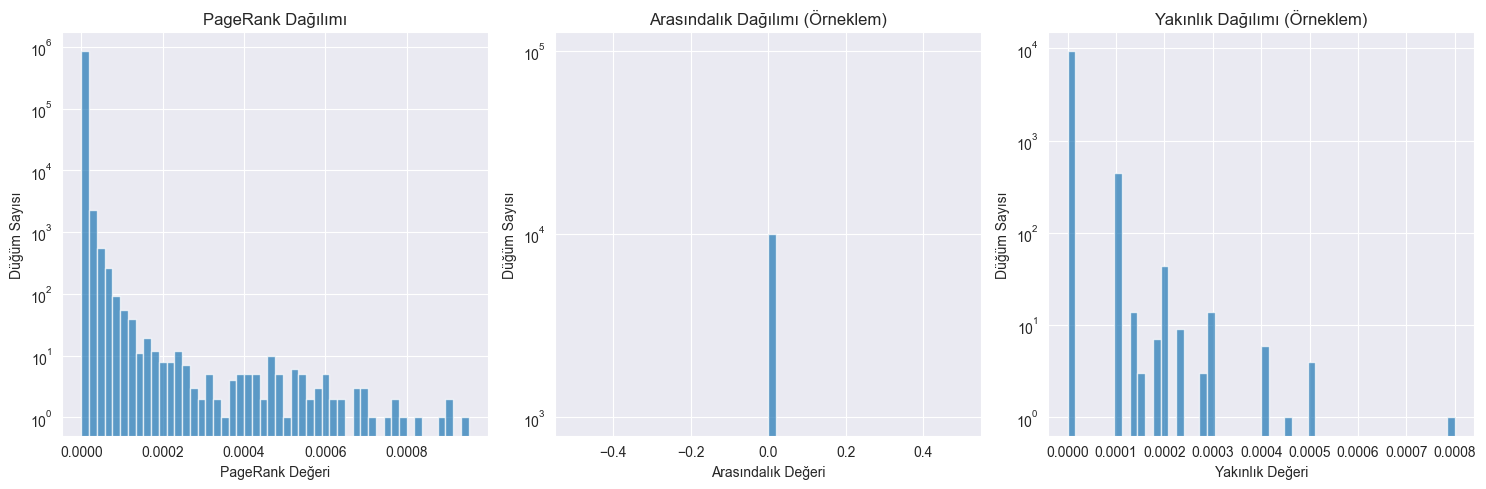

In [6]:
# Büyük graflar için merkezilik hesaplaması zaman alabilir
# Örnekleme ile çalışmak daha etkili olabilir
print("Merkezilik ölçümleri hesaplanıyor (bu işlem zaman alabilir)...")

# Örneklemek için bir altgraf oluşturuyoruz
# Büyük veri setleri için bu gerekli, aksi takdirde hesaplama çok uzun sürer
sample_size = min(10000, G.number_of_nodes())
sample_nodes = np.random.choice(list(G.nodes()), size=sample_size, replace=False)
subgraph = G.subgraph(sample_nodes)

print(f"Örnekleme için {sample_size} düğüm seçildi")
print(f"Altgraf boyutu: {subgraph.number_of_nodes()} düğüm, {subgraph.number_of_edges()} kenar")

# PageRank - Tüm graf üzerinde hesaplanabilir, göreceli olarak daha hızlı
start_time = time.time()
print("PageRank hesaplanıyor...")
pagerank = nx.pagerank(G, alpha=0.85, max_iter=100)
print(f"PageRank hesaplama süresi: {time.time() - start_time:.2f} saniye")

# Betweenness (Arasındalık) - Örneklem üzerinde
start_time = time.time()
print("Arasındalık merkeziliği hesaplanıyor...")
betweenness = nx.betweenness_centrality(subgraph, k=100, normalized=True)
print(f"Arasındalık merkeziliği hesaplama süresi: {time.time() - start_time:.2f} saniye")

# Closeness (Yakınlık) - Örneklem üzerinde
start_time = time.time()
print("Yakınlık merkeziliği hesaplanıyor...")
closeness = nx.closeness_centrality(subgraph)
print(f"Yakınlık merkeziliği hesaplama süresi: {time.time() - start_time:.2f} saniye")

# En yüksek değerlere sahip düğümlerin merkezilik ölçümlerini yazdırıyoruz
print("\nEn yüksek PageRank değerleri:")
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
for node, score in top_pagerank:
    print(f"Düğüm {node}: {score:.6f}")

# Örneklemden en yüksek betweenness değerleri
print("\nEn yüksek Arasındalık değerleri (örneklem):")
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
for node, score in top_betweenness:
    print(f"Düğüm {node}: {score:.6f}")

# Örneklemden en yüksek closeness değerleri
print("\nEn yüksek Yakınlık değerleri (örneklem):")
top_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]
for node, score in top_closeness:
    print(f"Düğüm {node}: {score:.6f}")

# Merkezilik dağılımlarının görselleştirilmesi
plt.figure(figsize=(15, 5))

# PageRank dağılımı
plt.subplot(1, 3, 1)
pagerank_values = list(pagerank.values())
plt.hist(pagerank_values, bins=50, alpha=0.7)
plt.title('PageRank Dağılımı')
plt.xlabel('PageRank Değeri')
plt.ylabel('Düğüm Sayısı')
plt.yscale('log')  # Log ölçeği kullanarak dağılımı daha iyi görebiliriz

# Arasındalık dağılımı
plt.subplot(1, 3, 2)
betweenness_values = list(betweenness.values())
plt.hist(betweenness_values, bins=50, alpha=0.7)
plt.title('Arasındalık Dağılımı (Örneklem)')
plt.xlabel('Arasındalık Değeri')
plt.ylabel('Düğüm Sayısı')
plt.yscale('log')

# Yakınlık dağılımı
plt.subplot(1, 3, 3)
closeness_values = list(closeness.values())
plt.hist(closeness_values, bins=50, alpha=0.7)
plt.title('Yakınlık Dağılımı (Örneklem)')
plt.xlabel('Yakınlık Değeri')
plt.ylabel('Düğüm Sayısı')
plt.yscale('log')

plt.tight_layout()
plt.savefig('centrality_distributions.png', dpi=300)
plt.show()

## 6. Yapısal Özellikler

### Kümelenme Katsayısı (Clustering Coefficient)

Kümelenme katsayısı, bir düğümün komşularının birbirleriyle ne kadar bağlantılı olduğunu ölçer. Yüksek kümelenme, düğümlerin sıkıca bağlı topluluklar oluşturma eğilimini gösterir.


Kümelenme katsayısı hesaplanıyor...
Ortalama kümelenme katsayısı (örneklem): 0.0036
Kümelenme katsayısı hesaplama süresi: 0.09 saniye


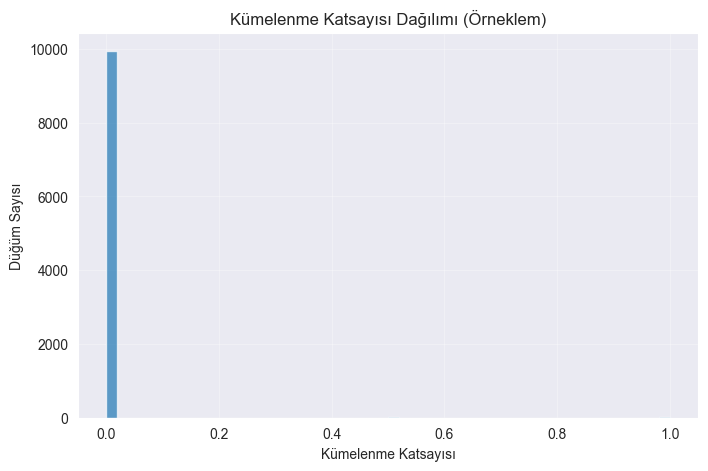

In [7]:
print("Kümelenme katsayısı hesaplanıyor...")
start_time = time.time()

# Directed grafiğin yönlü kümelenme katsayısını hesaplıyoruz
# Büyük graflar için bu işlem zaman alabilir, örnekleme yapılabilir
try:
    cluster_coef = nx.clustering(subgraph)
    avg_cluster_coef = np.mean(list(cluster_coef.values()))
    print(f"Ortalama kümelenme katsayısı (örneklem): {avg_cluster_coef:.4f}")
    print(f"Kümelenme katsayısı hesaplama süresi: {time.time() - start_time:.2f} saniye")

    # Kümelenme katsayısı dağılımı
    plt.figure(figsize=(8, 5))
    plt.hist(list(cluster_coef.values()), bins=50, alpha=0.7)
    plt.title('Kümelenme Katsayısı Dağılımı (Örneklem)')
    plt.xlabel('Kümelenme Katsayısı')
    plt.ylabel('Düğüm Sayısı')
    plt.grid(True, alpha=0.3)
    plt.savefig('clustering_coefficient_distribution.png', dpi=300)
    plt.show()

except Exception as e:
    print(f"Kümelenme katsayısı hesaplanamadı: {e}")

### Üçgenler ve Geçiş Oranı

Üçgenler, birbirine bağlı üç düğümden oluşan alt grafları temsil eder. Geçiş oranı (transitivity), bir grafta olası üçgenlerin gerçekleşme oranını ölçer.
Transitivity = 3 * (üçgen sayısı) / (bağlantılı üçlü sayısı)


In [8]:
# Geçiş oranı hesaplama
print("\nGeçiş oranı hesaplanıyor...")
start_time = time.time()

try:
    transitivity = nx.transitivity(subgraph)
    print(f"Geçiş oranı (örneklem): {transitivity:.4f}")
    print(f"Geçiş oranı hesaplama süresi: {time.time() - start_time:.2f} saniye")
except Exception as e:
    print(f"Geçiş oranı hesaplanamadı: {e}")


Geçiş oranı hesaplanıyor...
Geçiş oranı (örneklem): 0.4257
Geçiş oranı hesaplama süresi: 0.05 saniye


### Assortativity (Tercihli Bağlantı)

Assortativity, benzer derece değerlerine sahip düğümlerin birbirine bağlanma eğilimini ölçer. Pozitif değerler, benzer derece değerlerine sahip düğümlerin birbirine bağlanma eğilimini gösterirken, negatif değerler farklı derece değerlerine sahip düğümlerin birbirine bağlanma eğilimini gösterir.


In [9]:
# Assortativity hesaplama
print("\nAssortativity hesaplanıyor...")
start_time = time.time()

try:
    assortativity = nx.degree_assortativity_coefficient(G)
    print(f"Derece assortativity katsayısı: {assortativity:.4f}")
    print(f"Assortativity hesaplama süresi: {time.time() - start_time:.2f} saniye")
except Exception as e:
    print(f"Assortativity hesaplanamadı: {e}")


Assortativity hesaplanıyor...
Derece assortativity katsayısı: -0.0652
Assortativity hesaplama süresi: 7.19 saniye


### Ağ Yoğunluğu

Ağ yoğunluğu, mevcut bağlantıların, olası tüm bağlantılara oranını ifade eder. Yönlü bir graf için bu, |E| / (|V| × (|V| - 1)) formülüyle hesaplanır.


In [10]:
# Ağ yoğunluğu hesaplama
density = nx.density(G)
print(f"Ağ yoğunluğu: {density:.8f}")

Ağ yoğunluğu: 0.00000666


## 7. Topluluk Tespiti

Topluluk tespiti, bir ağdaki yoğun bağlantılı düğüm gruplarını (toplulukları) belirlemeye çalışır. Web ağları gibi büyük ağlarda, bu topluluklar genellikle ortak bir konuya veya içeriğe sahip web sayfaları kümelerini temsil eder.

Not: Büyük ağlarda topluluk tespiti hesaplamalı olarak pahalıdır, bu yüzden örnekleme yapılmış bir altgraf üzerinde çalışıyoruz.


Topluluk tespiti yapılıyor (bu işlem zaman alabilir)...
Topluluk tespiti için örneklem boyutu: 5000 düğüm, 112 kenar

Louvain algoritması ile topluluk tespiti yapılıyor...
Tespit edilen topluluk sayısı: 4891
Ortalama topluluk boyutu: 1.02
Medyan topluluk boyutu: 1.00
Minimum topluluk boyutu: 1
Maksimum topluluk boyutu: 5


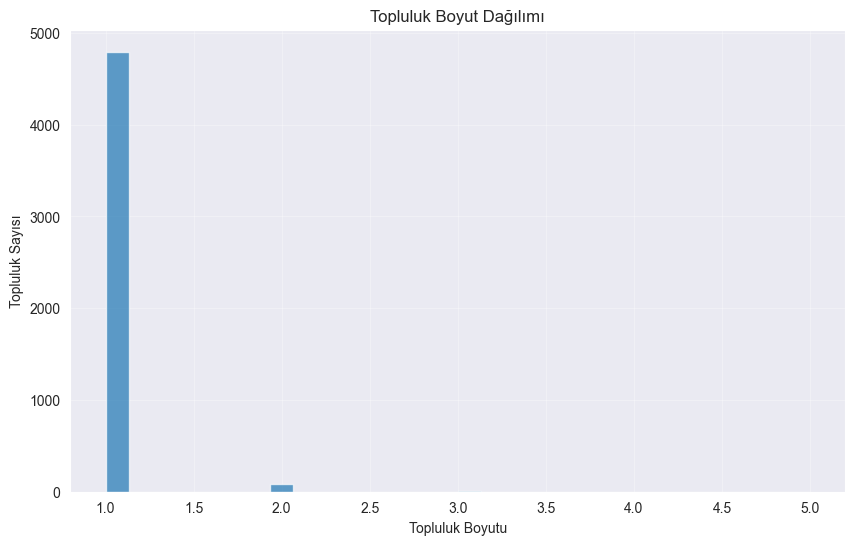

Modülerlik: 0.9863
Topluluk tespiti süresi: 0.64 saniye


In [11]:
# Topluluk tespiti
print("Topluluk tespiti yapılıyor (bu işlem zaman alabilir)...")
start_time = time.time()

# Büyük ağlarda topluluk tespiti için daha küçük bir örneklem kullanıyoruz
community_sample_size = min(5000, G.number_of_nodes())
community_sample = np.random.choice(list(G.nodes()), size=community_sample_size, replace=False)
community_subgraph = G.subgraph(community_sample)

# Yönlü grafı yönsüz grafa dönüştürerek topluluk tespiti yapıyoruz
undirected_subgraph = nx.Graph(community_subgraph)
print(f"Topluluk tespiti için örneklem boyutu: {undirected_subgraph.number_of_nodes()} düğüm, {undirected_subgraph.number_of_edges()} kenar")

try:
    # Louvain algoritması ile topluluk tespiti
    print("\nLouvain algoritması ile topluluk tespiti yapılıyor...")
    from community import community_louvain

    partition = community_louvain.best_partition(undirected_subgraph)
    communities = {}
    for node, comm_id in partition.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)

    print(f"Tespit edilen topluluk sayısı: {len(communities)}")

    # Topluluk boyutlarını yazdırıyoruz
    community_sizes = [len(nodes) for nodes in communities.values()]
    print(f"Ortalama topluluk boyutu: {np.mean(community_sizes):.2f}")
    print(f"Medyan topluluk boyutu: {np.median(community_sizes):.2f}")
    print(f"Minimum topluluk boyutu: {min(community_sizes)}")
    print(f"Maksimum topluluk boyutu: {max(community_sizes)}")

    # Toplulukların boyut dağılımı
    plt.figure(figsize=(10, 6))
    plt.hist(community_sizes, bins=30, alpha=0.7)
    plt.title('Topluluk Boyut Dağılımı')
    plt.xlabel('Topluluk Boyutu')
    plt.ylabel('Topluluk Sayısı')
    plt.grid(True, alpha=0.3)
    plt.savefig('community_size_distribution.png', dpi=300)
    plt.show()

    # Modülerlik hesaplama
    modularity = community_louvain.modularity(partition, undirected_subgraph)
    print(f"Modülerlik: {modularity:.4f}")

except Exception as e:
    print(f"Topluluk tespiti yapılamadı: {e}")

print(f"Topluluk tespiti süresi: {time.time() - start_time:.2f} saniye")


## 8. Çekirdek-Çevre Analizi (K-core Decomposition)

K-core, bir grafın alt grafıdır ve bu alt grafta her düğümün en az k derecesi vardır. K-core analizi, bir ağın hiyerarşik yapısını ve bağlantı desenleri hakkında bilgi verir.


K-core analizi yapılıyor...
Maksimum k-core değeri: 44


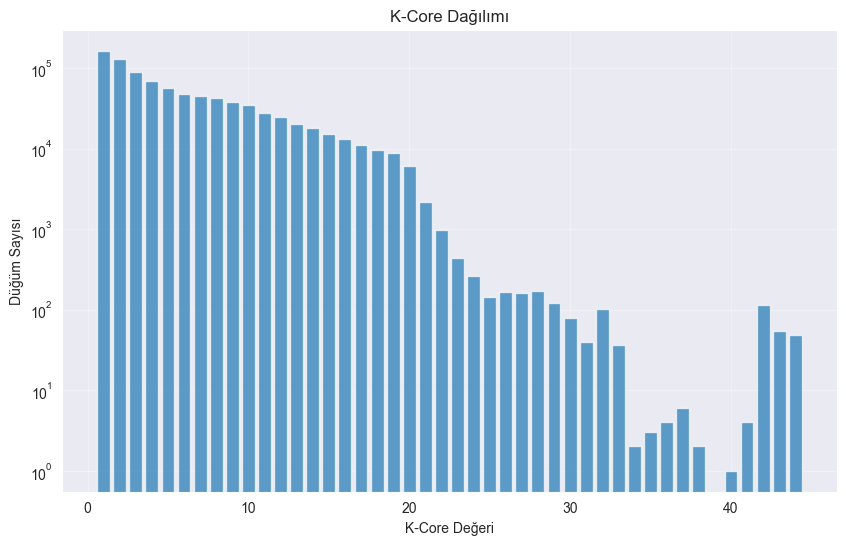


En yüksek k-core değerleri:
Düğüm 801164: 44
Düğüm 595324: 44
Düğüm 21260: 44
Düğüm 23749: 44
Düğüm 32719: 44
Düğüm 40569: 44
Düğüm 52834: 44
Düğüm 75564: 44
Düğüm 76012: 44
Düğüm 100246: 44
K-core analizi süresi: 31.51 saniye


In [12]:
# K-core analizi
print("K-core analizi yapılıyor...")
start_time = time.time()

try:
    # Yönlü grafı yönsüz grafa dönüştürerek k-core analizi yapıyoruz
    undirected_G = nx.Graph(G)

    # Her düğümün core numarasını hesaplıyoruz
    core_numbers = nx.core_number(undirected_G)

    # Core numaralarının dağılımı
    core_dist = Counter(core_numbers.values())

    print(f"Maksimum k-core değeri: {max(core_numbers.values())}")

    # Core sayılarının dağılımı
    plt.figure(figsize=(10, 6))
    x = sorted(core_dist.keys())
    y = [core_dist[k] for k in x]
    plt.bar(x, y, alpha=0.7)
    plt.title('K-Core Dağılımı')
    plt.xlabel('K-Core Değeri')
    plt.ylabel('Düğüm Sayısı')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log ölçeği kullanarak dağılımı daha iyi görebiliriz
    plt.savefig('kcore_distribution.png', dpi=300)
    plt.show()

    # En yüksek core değerlerine sahip düğümleri yazdırıyoruz
    print("\nEn yüksek k-core değerleri:")
    top_cores = sorted(core_numbers.items(), key=lambda x: x[1], reverse=True)[:10]
    for node, core in top_cores:
        print(f"Düğüm {node}: {core}")

except Exception as e:
    print(f"K-core analizi yapılamadı: {e}")

print(f"K-core analizi süresi: {time.time() - start_time:.2f} saniye")


## 9. Özet ve Sonuçlar

Web-Google ağı, Google'ın web sayfalarını temsil eden bir ağdır. Bu analiz, ağın yapısal özelliklerini ve karakteristiklerini ortaya çıkarmıştır.

Analizimizin başlıca bulguları:
1. Ağ büyük ölçekli ve karmaşık bir yapıya sahiptir.
2. Derece dağılımı, güç yasası özelliği göstermektedir, bu da bazı web sayfalarının çok sayıda bağlantıya sahip olduğunu, çoğunun ise göreceli olarak az bağlantıya sahip olduğunu gösterir.
3. Ağın düşük yoğunluğa sahip olması, web sayfaları arasındaki bağlantıların seyrektir.
4. Kümelenme katsayısı, web sayfalarının tematik olarak gruplanma eğilimini gösterir.
5. Topluluk tespiti, benzer içeriğe sahip web sayfalarının kümelerini tanımlar.
6. K-core analizi, ağın hiyerarşik yapısını ve bağlantı desenlerini gösterir.

Bu bulgular, web ağlarının doğası hakkında değerli bilgiler sağlar ve SEO, sosyal medya analizi ve web sayfası optimizasyonu gibi çeşitli alanlarda kullanılabilir.


## 10. Gephi İçin Veri Dışa Aktarma

Bu bölümde, ağ verilerini Gephi'de detaylı analiz için dışa aktarıyoruz. Veriyi GEXF (Graph Exchange XML Format) formatında dışa aktarıyoruz, bu Gephi'nin tercih ettiği bir formattır.


In [21]:
# Gephi için veri dışa aktarma
print("Gephi için veri dışa aktarma işlemi başlatılıyor...")

try:
    # Tüm ağ için dışa aktarma
    nx.write_gexf(G, "web_google_full.gexf")
    print(f"Tam ağ Gephi formatında dışa aktarıldı: web_google_full.gexf")

    # En büyük dereceli (en fazla bağlantıya sahip) düğümleri seçme
    # Düğümleri derecelerine göre sıralayalım
    node_degrees = dict(G.degree())
    # Düğümleri derece değerine göre azalan sırada sıralayalım
    sorted_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)

    sample_size_export = min(3500, G.number_of_nodes())
    sample_nodes_export = [node for node, degree in sorted_nodes[:sample_size_export]]

    # Seçilen düğümlerden oluşan alt grafiği oluşturalım
    export_subgraph = G.subgraph(sample_nodes_export)

    nx.write_gexf(export_subgraph, "web_google_sample.gexf")
    print(f"En büyük dereceli {sample_size_export} düğümden oluşan ağ Gephi formatında dışa aktarıldı: web_google_sample.gexf")

except Exception as e:
    print(f"Gephi için veri dışa aktarma sırasında hata oluştu: {e}")

print("Analiz ve dışa aktarma işlemleri tamamlandı.")

Gephi için veri dışa aktarma işlemi başlatılıyor...
Tam ağ Gephi formatında dışa aktarıldı: web_google_full.gexf
En büyük dereceli 3500 düğümden oluşan ağ Gephi formatında dışa aktarıldı: web_google_sample.gexf
Geliştirilmiş en büyük dereceli 3500 düğümlü ağ Gephi formatında dışa aktarıldı: web_google_enhanced.gexf
Analiz ve dışa aktarma işlemleri tamamlandı.
